# Figure 2

In [38]:
run doomed.py

In [58]:
import pickle as pk
import pandas as pd
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

## **(A–C)** Population dynamics and extinction time

$n_0=10^3$ mutation-free individuals subject to mutations with deleterious effect $s=0.06$ and rate $u=0.02$. 

### Stochastic simulations

$10^4$ replicate populations.

**Note:** The following cell performs simulations and saves the resulting data.  This takes approximately 10 minutes.  Skip to the following cell to use previously saved data.

In [3]:
%%time
# simulate data
nn = []
tt = []
for i in range(10000):
    if (i % 100 == 0):
        print('.', sep='', end='')
    n, t = sim([1000], .06, .02)
    nn.append(n)
    tt.append(t)
tt = np.array(tt)
# save simulated data
pd.Series(tt).to_csv('data/fig2times.csv')
pk.dump(nn, open('data/fig2traj.pickle', 'wb'))

....................................................................................................CPU times: user 8min 28s, sys: 1.65 s, total: 8min 30s
Wall time: 8min 36s


Load the results from earlier simulations

In [ ]:
# read simulated data
tt = np.array(pd.read_csv('data/fig2times.csv', index_col=0, names='t'), dtype=int)
nn = pk.load(open('data/fig2traj.pickle', 'rb'))

In [5]:
nmat = np.zeros((max(tt) + 1, len(nn)))
for i in range(len(nn)):
    for j in range(len(nn[i])):
        nmat[j,i] = nn[i][j]

### Theory

Expected population size up to $t=400$ generations

In [25]:
nexp = [N(1000, .06, .02, t) for t in range(401)]
print(nexp[-5:])

[0.47040874335886707, 0.46100056849190457, 0.4517805571222643, 0.4427449459800012, 0.4338900470605692]


In [22]:
# expected extinction time
Texp, Tvar = T(1000, .06, .02, 1e-6, False, True)
print(Texp, Tvar)

220.30923866132412 4057.8527987482043


## **(D)** Effect of population size on extinction time

Set $u = s = 0.01$ and vary $n_0$ between 10 and $10^{5}$.

### Stochastic simulations

**Note:** skip the next three cells unless you want to rerun the simulations.

In [ ]:
logn = np.linspace(1, 5, 41)
logn

In [ ]:
print 'N T Tstd'
for x in logn:
    T = simult([int(10**x)], .01, .01, 10000)
    print int(10**x), T.mean(), T.std(ddof=1)

In [ ]:
# save simulated data
fig2sim = pd.read_clipboard(sep=' ')
fig2sim.to_csv('data/fig2sim.csv')

In [ ]:
# read simulated data
fig2sim = pd.read_csv('data/fig2sim.csv', index_col=0)
fig2sim['logN'] = np.log10(fig2sim['N'])
fig2sim.head()

### Theory

**Note:** skip the next two cells unless you want to rerun the simulations.

In [ ]:
print 'N T Tstd'
for x in logn:
    t, v = T(10**x, .01, .01, 1e-6, False, True)
    print int(10**x), t, np.sqrt(v)

In [ ]:
# save theoretical values
fig2theory = pd.read_clipboard(sep=' ')
fig2theory.to_csv('data/fig2theory.csv')

In [ ]:
# read theoretical values
fig2theory = pd.read_csv('data/fig2theory.csv', index_col=0)
fig2theory['logN'] = np.log10(fig2theory['N'])
fig2theory.head()

## Plot

In [42]:
tmax = 401
t = range(tmax)
m = nmat.mean(axis=1)[:tmax]
s = nmat.std(axis=1, ddof=1)[:tmax]

In [17]:
# maximum extinction time
tt.max()

684

In [95]:
ttkm = tt.copy()
# censor extinction times > 600
ttkm[tt > 600] = 600
cens = np.ones(10000)
cens[tt > 600] = 0
kmf.fit(ttkm, event_observed=cens, label='')

<lifelines.KaplanMeierFitter: fitted with 10000 observations, 4 censored>

No handles with labels found to put in legend.


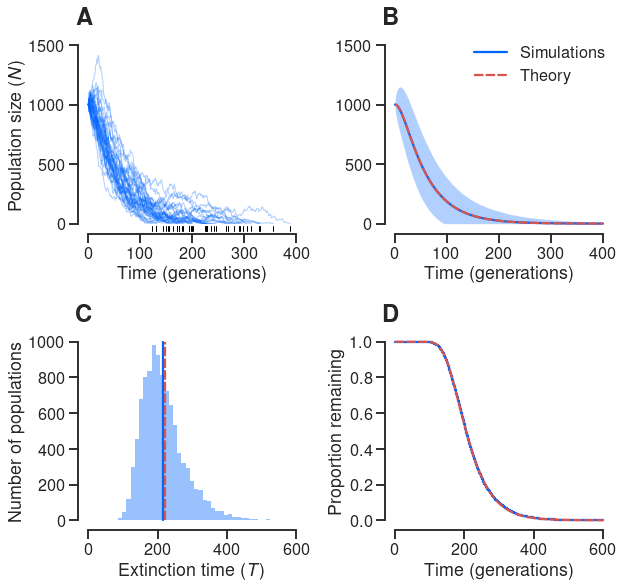

In [185]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8.5, 8))

red = sns.xkcd_rgb["pale red"]
blu = sns.xkcd_rgb["bright blue"]

fig.subplots_adjust()

set_up_axes(ax1, xmin=0, xmax=400, xstep=100, ymin=0, ymax=1500, ystep=500, rnd=0, 
    ylabel=r'Population size $(N)$', xlabel='Time (generations)', part_label=r'\textbf{A}')
set_up_axes(ax2, xmin=0, xmax=400, xstep=100, ymin=0, ymax=1500, ystep=500, rnd=0, 
    ylabel=r'', xlabel='Time (generations)', part_label=r'\textbf{B}')
set_up_axes(ax3, xmin=0, xmax=600, xstep=200, ymin=0, ymax=1000, ystep=200, rnd=0, 
    ylabel='Number of populations', xlabel='Extinction time $(T)$', part_label=r'\textbf{C}')
set_up_axes(ax4, xmin=0, xmax=600, xstep=200, ymin=0, ymax=1, ystep=.2, rnd=1, 
    ylabel='Proportion remaining', xlabel='Time (generations)', part_label=r'\textbf{D}')

ax1.set_position([.135, .620, .34, .31])
ax2.set_position([.636, .620, .34, .31])
ax3.set_position([.135, .105, .34, .31])
ax4.set_position([.636, .105, .34, .31])

for i in range(1920, 1960):
    ax1.plot(nn[i], color=blu, alpha=.3, lw=1, clip_on=False)
    ax1.plot([tt[i]] * 2, [-20, -60], 'k-', clip_on=False, lw=1)
# ax1.plot([0, 1000], [1000] * 2, '--', color='0.60', lw=1.5)

lo = m - 2 * s
lo[lo<0] = 0
ax2.fill_between(t, m + 2 * s, lo, color=blu, alpha=.3, clip_on=False, lw=0)
ax2.plot(t, m, clip_on=False, label='Simulations', color=blu)
ax2.plot(t, nexp, '--', color=red, clip_on=False, label='Theory', dashes=[4.2, 1.])
ax2.legend(frameon=False, bbox_to_anchor=(1.08, 1.08))

sns.distplot(tt, kde=False, ax=ax3, color=blu, hist_kws=dict(linewidth=0))
ax3.plot([tt.mean()] * 2, [0, 1000], color=blu, clip_on=False)
ax3.plot([Texp] * 2, [0, 1000], '--', color=red, clip_on=False, dashes=[4.2, 1.])
# ax3.legend()

# ax4.plot(fig2theory['logN'], fig2theory['T'], color=red)
# ax4.plot(fig2sim['logN'], fig2sim['T'], color=blu)
# ax4.fill_between(fig2sim['logN'], fig2sim['T'] + fig2sim['Tstd'], fig2sim['T'] - fig2sim['Tstd'], 
#     color=blu, alpha=.3, lw=0, clip_on=False)
ax4.set_xticklabels(range(0, 601, 200))
kmf.plot(ax=ax4, color=blu, clip_on=False)
ax4.plot(propexp, '--', color=red, clip_on=False, dashes=[4.2, 1.])
ax4.legend(frameon=False)
ax4.set_xlabel('Time (generations)')

plt.savefig('../figures/fig2.pdf')

In [97]:
propexp = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., \
    1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., \
    0.999999, 0.999999, 0.999999, 0.999998, 0.999998, 0.999997, 0.999995, 0.999994, 0.999992, 0.999989, 0.999985, 0.99998, 0.999974, 0.999966, \
    0.999956, 0.999944, 0.999929, 0.99991, 0.999888, 0.99986, 0.999827, 0.999786, 0.999739, 0.999682, 0.999615, 0.999536, 0.999444, 0.999337, \
    0.999213, 0.99907, 0.998906, 0.998719, 0.998506, 0.998264, 0.99799, 0.997683, 0.997338, 0.996953, 0.996523, 0.996047, 0.99552, 0.994938, \
    0.994298, 0.993596, 0.992829, 0.991992, 0.991081, 0.990093, 0.989024, 0.98787, 0.986626, 0.98529, 0.983858, 0.982325, 0.980688, 0.978945, \
    0.977091, 0.975123, 0.973039, 0.970835, 0.968509, 0.966059, 0.963481, 0.960775, 0.957937, 0.954967, 0.951862, 0.948623, 0.945246, 0.941733, \
    0.938082, 0.934293, 0.930366, 0.926301, 0.922098, 0.917758, 0.913282, 0.908671, 0.903926, 0.899048, 0.894039, 0.888902, 0.883637, 0.878248, \
    0.872736, 0.867104, 0.861355, 0.855492, 0.849518, 0.843435, 0.837246, 0.830957, 0.824568, 0.818085, 0.811511, 0.804849, 0.798103, 0.791277, \
    0.784375, 0.7774, 0.770357, 0.763249, 0.756081, 0.748856, 0.741578, 0.734251, 0.726879, 0.719466, 0.712015, 0.704531, 0.697018, 0.689479, \
    0.681917, 0.674337, 0.666743, 0.659136, 0.651522, 0.643903, 0.636283, 0.628666, 0.621053, 0.613449, 0.605856, 0.598278, 0.590716, 0.583175, \
    0.575657, 0.568164, 0.560699, 0.553264, 0.545862, 0.538494, 0.531164, 0.523874, 0.516624, 0.509418, 0.502257, 0.495143, 0.488077, 0.481062, \
    0.474098, 0.467187, 0.460331, 0.453531, 0.446787, 0.440102, 0.433476, 0.42691, 0.420406, 0.413963, 0.407584, 0.401267, 0.395016, 0.388829, \
    0.382707, 0.376651, 0.370662, 0.364739, 0.358884, 0.353096, 0.347375, 0.341723, 0.336138, 0.330621, 0.325172, 0.319792, 0.314479, 0.309234, \
    0.304058, 0.298949, 0.293908, 0.288934, 0.284027, 0.279187, 0.274414, 0.269707, 0.265067, 0.260491, 0.255981, 0.251536, 0.247156, 0.242839, \
    0.238586, 0.234396, 0.230268, 0.226203, 0.222199, 0.218256, 0.214373, 0.210551, 0.206787, 0.203083, 0.199436, 0.195847, 0.192315, 0.188839, \
    0.185419, 0.182055, 0.178744, 0.175488, 0.172284, 0.169134, 0.166035, 0.162988, 0.159991, 0.157044, 0.154147, 0.151299, 0.148498, 0.145745, \
    0.143039, 0.14038, 0.137765, 0.135196, 0.132671, 0.13019, 0.127752, 0.125356, 0.123002, 0.12069, 0.118418, 0.116186, 0.113993, 0.11184, \
    0.109724, 0.107647, 0.105606, 0.103602, 0.101634, 0.0997008, 0.0978028, 0.0959391, 0.0941091, 0.0923123, 0.0905481, 0.0888161, \
    0.0871156, 0.0854463, 0.0838075, 0.0821988, 0.0806196, 0.0790696, 0.0775481, 0.0760547, 0.074589, 0.0731505, 0.0717386, 0.070353, \
    0.0689933, 0.0676588, 0.0663494, 0.0650644, 0.0638034, 0.0625662, 0.0613521, 0.0601609, 0.0589921, 0.0578454, 0.0567203, 0.0556165, \
    0.0545335, 0.0534711, 0.0524288, 0.0514063, 0.0504033, 0.0494193, 0.0484541, 0.0475072, 0.0465785, 0.0456674, 0.0447738, 0.0438973, \
    0.0430376, 0.0421944, 0.0413673, 0.0405561, 0.0397605, 0.0389803, 0.038215, 0.0374645, 0.0367284, 0.0360066, 0.0352987, 0.0346045, \
    0.0339237, 0.033256, 0.0326013, 0.0319593, 0.0313298, 0.0307124, 0.030107, 0.0295134, 0.0289314, 0.0283606, 0.027801, 0.0272522, \
    0.0267141, 0.0261866, 0.0256693, 0.0251621, 0.0246648, 0.0241772, 0.0236992, 0.0232305, 0.0227709, 0.0223204, 0.0218786, 0.0214455, \
    0.0210209, 0.0206047, 0.0201966, 0.0197965, 0.0194042, 0.0190196, 0.0186426, 0.0182731, 0.0179107, 0.0175555, 0.0172073, 0.0168659, \
    0.0165313, 0.0162032, 0.0158816, 0.0155663, 0.0152573, 0.0149543, 0.0146573, 0.0143662, 0.0140808, 0.013801, 0.0135268, 0.013258, \
    0.0129944, 0.0127361, 0.0124829, 0.0122347, 0.0119914, 0.0117529, 0.0115192, 0.01129, 0.0110654, 0.0108453, 0.0106295, 0.0104179, \
    0.0102106, 0.0100073, 0.00980813, 0.00961286, 0.00942147, 0.00923387, 0.00904999, 0.00886975, 0.00869309, 0.00851994, 0.00835022, \
    0.00818386, 0.00802081, 0.007861, 0.00770435, 0.00755082, 0.00740034, 0.00725284, 0.00710828, 0.00696658, 0.0068277, 0.00669158, \
    0.00655817, 0.00642741, 0.00629925, 0.00617363, 0.00605051, 0.00592984, 0.00581158, 0.00569566, 0.00558205, 0.0054707, \
    0.00536156, 0.0052546, 0.00514977, 0.00504702, 0.00494632, 0.00484762, 0.00475088, 0.00465608, 0.00456316, 0.00447209, \
    0.00438283, 0.00429536, 0.00420962, 0.00412559, 0.00404324, 0.00396253, 0.00388342, 0.0038059, 0.00372991, 0.00365544, \
    0.00358246, 0.00351093, 0.00344083, 0.00337212, 0.00330478, 0.00323879, 0.00317411, 0.00311072, 0.0030486, 0.00298771, \
    0.00292804, 0.00286956, 0.00281225, 0.00275608, 0.00270103, 0.00264707, 0.0025942, 0.00254238, 0.00249159, 0.00244181, \
    0.00239303, 0.00234523, 0.00229837, 0.00225246, 0.00220745, 0.00216335, 0.00212013, 0.00207777, 0.00203625, 0.00199556, \
    0.00195569, 0.00191661, 0.00187831, 0.00184078, 0.001804, 0.00176795, 0.00173262, 0.00169799, 0.00166406, 0.0016308, 0.00159821, \
    0.00156627, 0.00153497, 0.00150429, 0.00147423, 0.00144476, 0.00141589, 0.00138759, 0.00135985, 0.00133267, 0.00130604, \
    0.00127993, 0.00125435, 0.00122928, 0.00120471, 0.00118063, 0.00115703, 0.0011339, 0.00111123, 0.00108902, 0.00106725, \
    0.00104591, 0.00102501, 0.00100452, 0.000984435, 0.000964756, 0.000945469, 0.000926568, 0.000908045, 0.000889892, 0.000872101, \
    0.000854666, 0.00083758, 0.000820835, 0.000804424, 0.000788342, 0.000772581, 0.000757135, 0.000741997, 0.000727162, 0.000712624, \
    0.000698376, 0.000684413, 0.000670729, 0.000657319, 0.000644177, 0.000631297, 0.000618675, 0.000606305, 0.000594182, 0.000582302, \
    0.000570659, 0.000559249, 0.000548067, 0.000537108, 0.000526369, 0.000515844, 0.00050553, 0.000495421, 0.000485515, 0.000475807, \
    0.000466293, 0.000456969, 0.000447832, 0.000438877, 0.000430101, 0.000421501, 0.000413073, 0.000404813, 0.000396718, 0.000388785, \
    0.000381011, 0.000373392, 0.000365925, 0.000358608, 0.000351437, 0.00034441, 0.000337522, 0.000330773, 0.000324159, 0.000317676, \
    0.000311324, 0.000305098, 0.000298997, 0.000293018, 0.000287159, 0.000281416, 0.000275789, 0.000270273, 0.000264869, 0.000259572, \
    0.000254381, 0.000249294, 0.000244309, 0.000239423, 0.000234635]

In [90]:
kmf.predict()

TypeError: predict() missing 1 required positional argument: 'time'

In [88]:
kmf.median_, np.median(tt)

(205.0, 205.0)

No handles with labels found to put in legend.


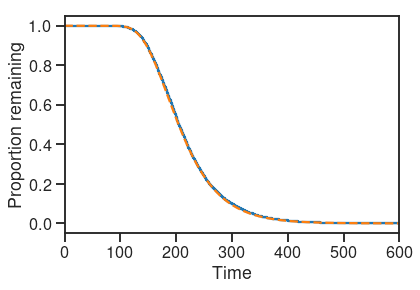

In [81]:
kmf.fit(tt, label='')
kmf.plot()
plt.plot(propexp, '--')
plt.xlim(0, 600)
plt.xlabel("Time")
plt.legend(frameon=False)
plt.ylabel("Proportion remaining");

In [48]:
!open ../figures/fig2.pdf

## Figure S1

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

red = sns.xkcd_rgb["pale red"]
blu = sns.xkcd_rgb["bright blue"]

fig.subplots_adjust()

set_up_axes(ax, xmin=1, xmax=5.01, xstep=1, ymin=0, ymax=1.6, ystep=.4, rnd=1, 
    xlabel=r'Initial population size $(n_0)$', ylabel=r'CV$[T]$', 
    part_label='')

ax.set_position([.18, .2, .79, .75])

ax.plot(fig2sim['logN'], fig2sim['Tstd'] / fig2sim['T'], 'o', ms=6,
    color=blu, label='Simulations', clip_on=False)
ax.plot(fig2theory['logN'], fig2theory['Tstd'] / fig2theory['T'], color=red, 
    label='Theory', clip_on=False)
ax.legend()

ax.set_xticklabels(['10', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$'])

plt.savefig('../figures/figS1.pdf')

In [31]:
tt.max()

684